In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [13]:
training_dir = 'animals/train'
test_dir = 'animals/val'

Create ImageDataGenerators

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to [0,1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,          # Randomly apply shearing transformations
    zoom_range=0.2,           # Randomly zoom in on images
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)


Converting a directory into a tf.data.Dataset

In [15]:
def generator_to_dataset(generator):
    def gen():
        for x, y in generator:
            yield x, y
    return tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, *(50, 50), 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 5), dtype=tf.float32)
        )
    )

Load images from the Directories

In [16]:
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size = (50, 50),
    batch_size=64,
    class_mode = 'categorical'
)

test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(50, 50),
    batch_size=64,
    class_mode = 'categorical'
)


Found 13474 images belonging to 5 classes.
Found 1497 images belonging to 5 classes.


Converting Genrators to tf.data.Dataset

In [17]:
train_dataset = generator_to_dataset(train_generator).repeat()
test_dataset = generator_to_dataset(test_generator).repeat()

Plotting the images randomly


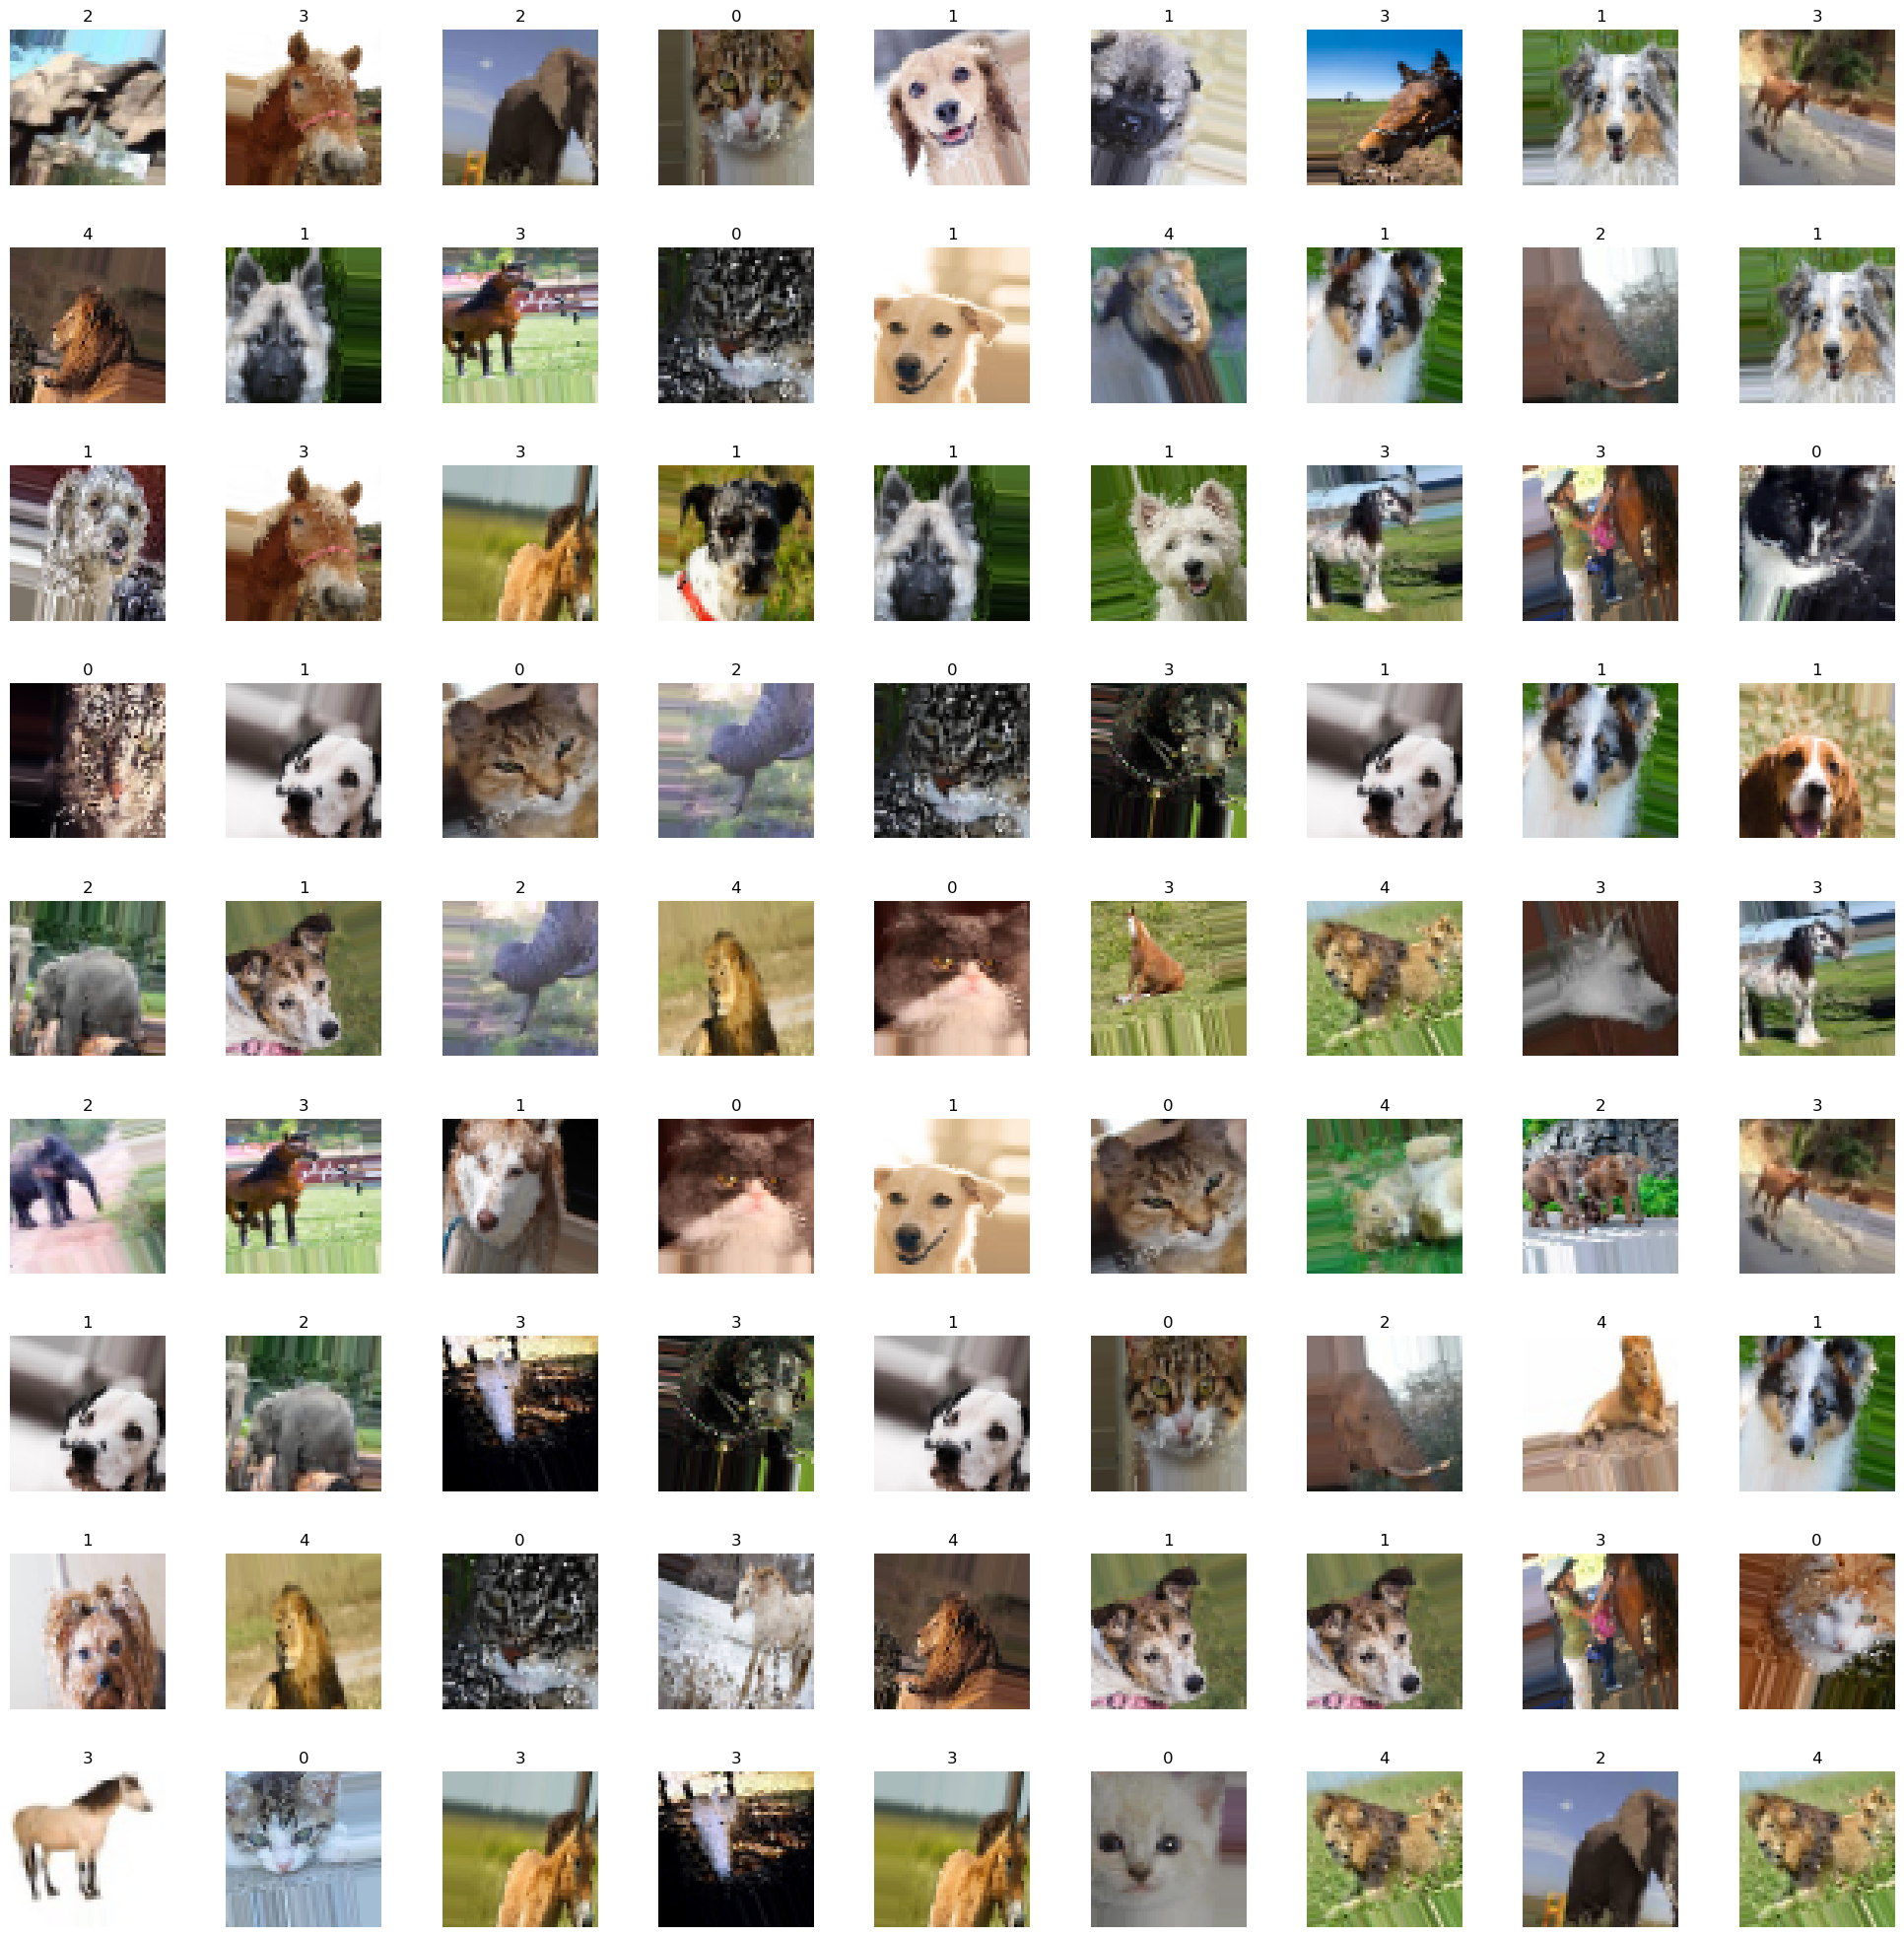

In [18]:
L_grid = 9
W_grid = 9

# Creating a figure with a grid of subplots
fig, axes = plt.subplots(L_grid, W_grid, figsize=(25, 25))
axes = axes.ravel()

# Getting a batch of images and labels from the generator
X_batch, y_batch = next(train_generator)

# Plotting the images and labels
for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, X_batch.shape[0])
    axes[i].imshow(X_batch[index])
    axes[i].set_title(np.argmax(y_batch[index]))
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)
plt.show()

Define the CNN Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam # Dense to run the connected neurons
from keras.callbacks import TensorBoard #Tensorflow working in the backend
from tensorflow.keras.layers import BatchNormalization



cnn_model = Sequential()
# Adding two convolution layers
cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(50, 50, 3)))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2, 2)) # downsizing the images to a 2 by 2



# Adding a drop out layer
#cnn_model.add(Dropout(0.5))

# Creating two extra convolution layers
cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2, 2)) # downsizing the images to a 2 by 2


# Creating two extra convolution layers
cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2, 2)) # downsizing the images to a 2 by 2

# Flattening of the images
cnn_model.add(Flatten())

# Connecting the Neurons
cnn_model.add(Dense(units= 128, activation='relu'))

# Adding another drop out layer
cnn_model.add(Dropout(0.5))

# Another Dense layer
cnn_model.add(Dense(units= 128, activation='relu'))

# Adding another drop out layer
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(units=train_generator.num_classes, activation='softmax'))



# try this
# A conv Layer kernel (5, 5), then a max pooling layer
# Another Conv Layer, then a max pooling layer
# Then Flatten.
# Then add the dense layer
# And drop out 40-50%
# Then the softmax output activation
# Compile!

# Use Auto Encoders so input and output size are the same.


Compile the Model

In [20]:
optimizer = Adam(learning_rate=0.0001)

cnn_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# import tensorflow as tf

# # Initialising the optimizer
# optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001)

# # Compiling the model
# cnn_model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [21]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 50, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 895,909 (3.42 MB)

 Trainable params: 895,013 (3.41 MB)

 Non-trainable params: 896 (3.50 KB)

Training the Model using Generators

In [22]:
# # Getting the total number of samples
# n_train_samples = train_generator.samples
# n_test_samples = test_generator.samples

# # Calculate the steps per epoch
# steps_per_epoch = n_train_samples // train_generator.batch_size
# validation_steps = n_test_samples // test_generator.batch_size

# # Ensuring both are atleast 1 to stop model from running out of data. 
# steps_per_epoch = max(steps_per_epoch, 1)
# validation_steps = max(validation_steps, 1)

# Using a learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Introducing early stopping to prevent model overfitting and generalization
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# # Train the model
# history = cnn_model.fit(
#     train_generator,
#     steps_per_epoch=steps_per_epoch,
#     validation_data=test_generator,
#     validation_steps=validation_steps,
#     epochs=200,
#     callbacks=[reduce_lr, early_stopping]
# )

history = cnn_model.fit(
    train_dataset,
    steps_per_epoch=len(train_generator),
    validation_data=test_dataset,
    validation_steps=len(test_generator),
    epochs=200,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 181s 842ms/step - accuracy: 0.2334 - loss: 1.9320 - val_accuracy: 0.1991 - val_loss: 2.2191 - learning_rate: 1.0000e-04
Epoch 2/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 85s 402ms/step - accuracy: 0.3114 - loss: 1.5473 - val_accuracy: 0.2599 - val_loss: 1.8711 - learning_rate: 1.0000e-04
Epoch 3/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 83s 392ms/step - accuracy: 0.3574 - loss: 1.4890 - val_accuracy: 0.4309 - val_loss: 1.3544 - learning_rate: 1.0000e-04
Epoch 4/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 83s 394ms/step - accuracy: 0.4200 - loss: 1.3999 - val_accuracy: 0.5164 - val_loss: 1.1934 - learning_rate: 1.0000e-04
Epoch 5/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 78s 370ms/step - accuracy: 0.4589 - loss: 1.3252 - val_accuracy: 0.5818 - val_loss: 1.0982 - learning_rate: 1.0000e-04
Epoch 6/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 77s 366ms/step - accuracy: 0.4912 - loss: 1.2619 - val_accuracy: 0.6286 - val_loss: 1.0066 - learning_rate: 1.0000e-04
Epoch 7/200
211/211 ━━━━━━━━━━━━━━━━━━━

Evaluating the Model

In [23]:
# evaluation = cnn_model.evaluate(test_generator, 
#                                 steps=test_generator.samples // test_generator.batch_size)
# print(f"Test Loss: {evaluation[0]}")
# print(f"Test Accuracy: {evaluation[1]}")


# Evaluate the model
evaluation = cnn_model.evaluate(
    test_dataset,
    steps=len(test_generator),
    verbose=1
)

print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")



24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.8591 - loss: 0.3619
Test Loss: 0.37407517433166504
Test Accuracy: 0.8663994669914246


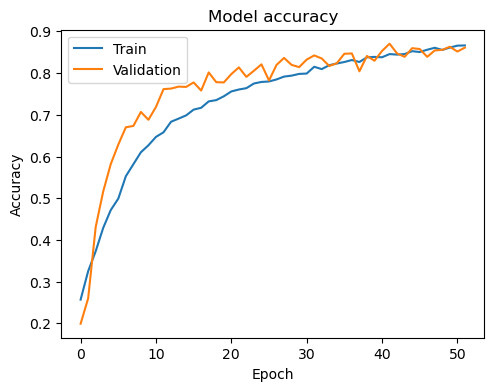

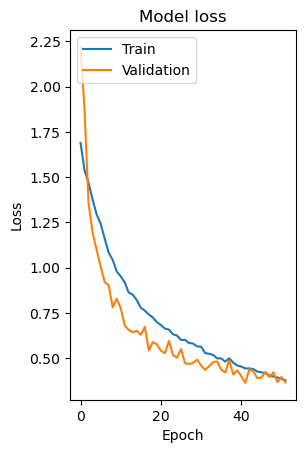

In [24]:
# Plot the training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


# Plotting the training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Plotting the Images with their Predicted and Actual Classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 


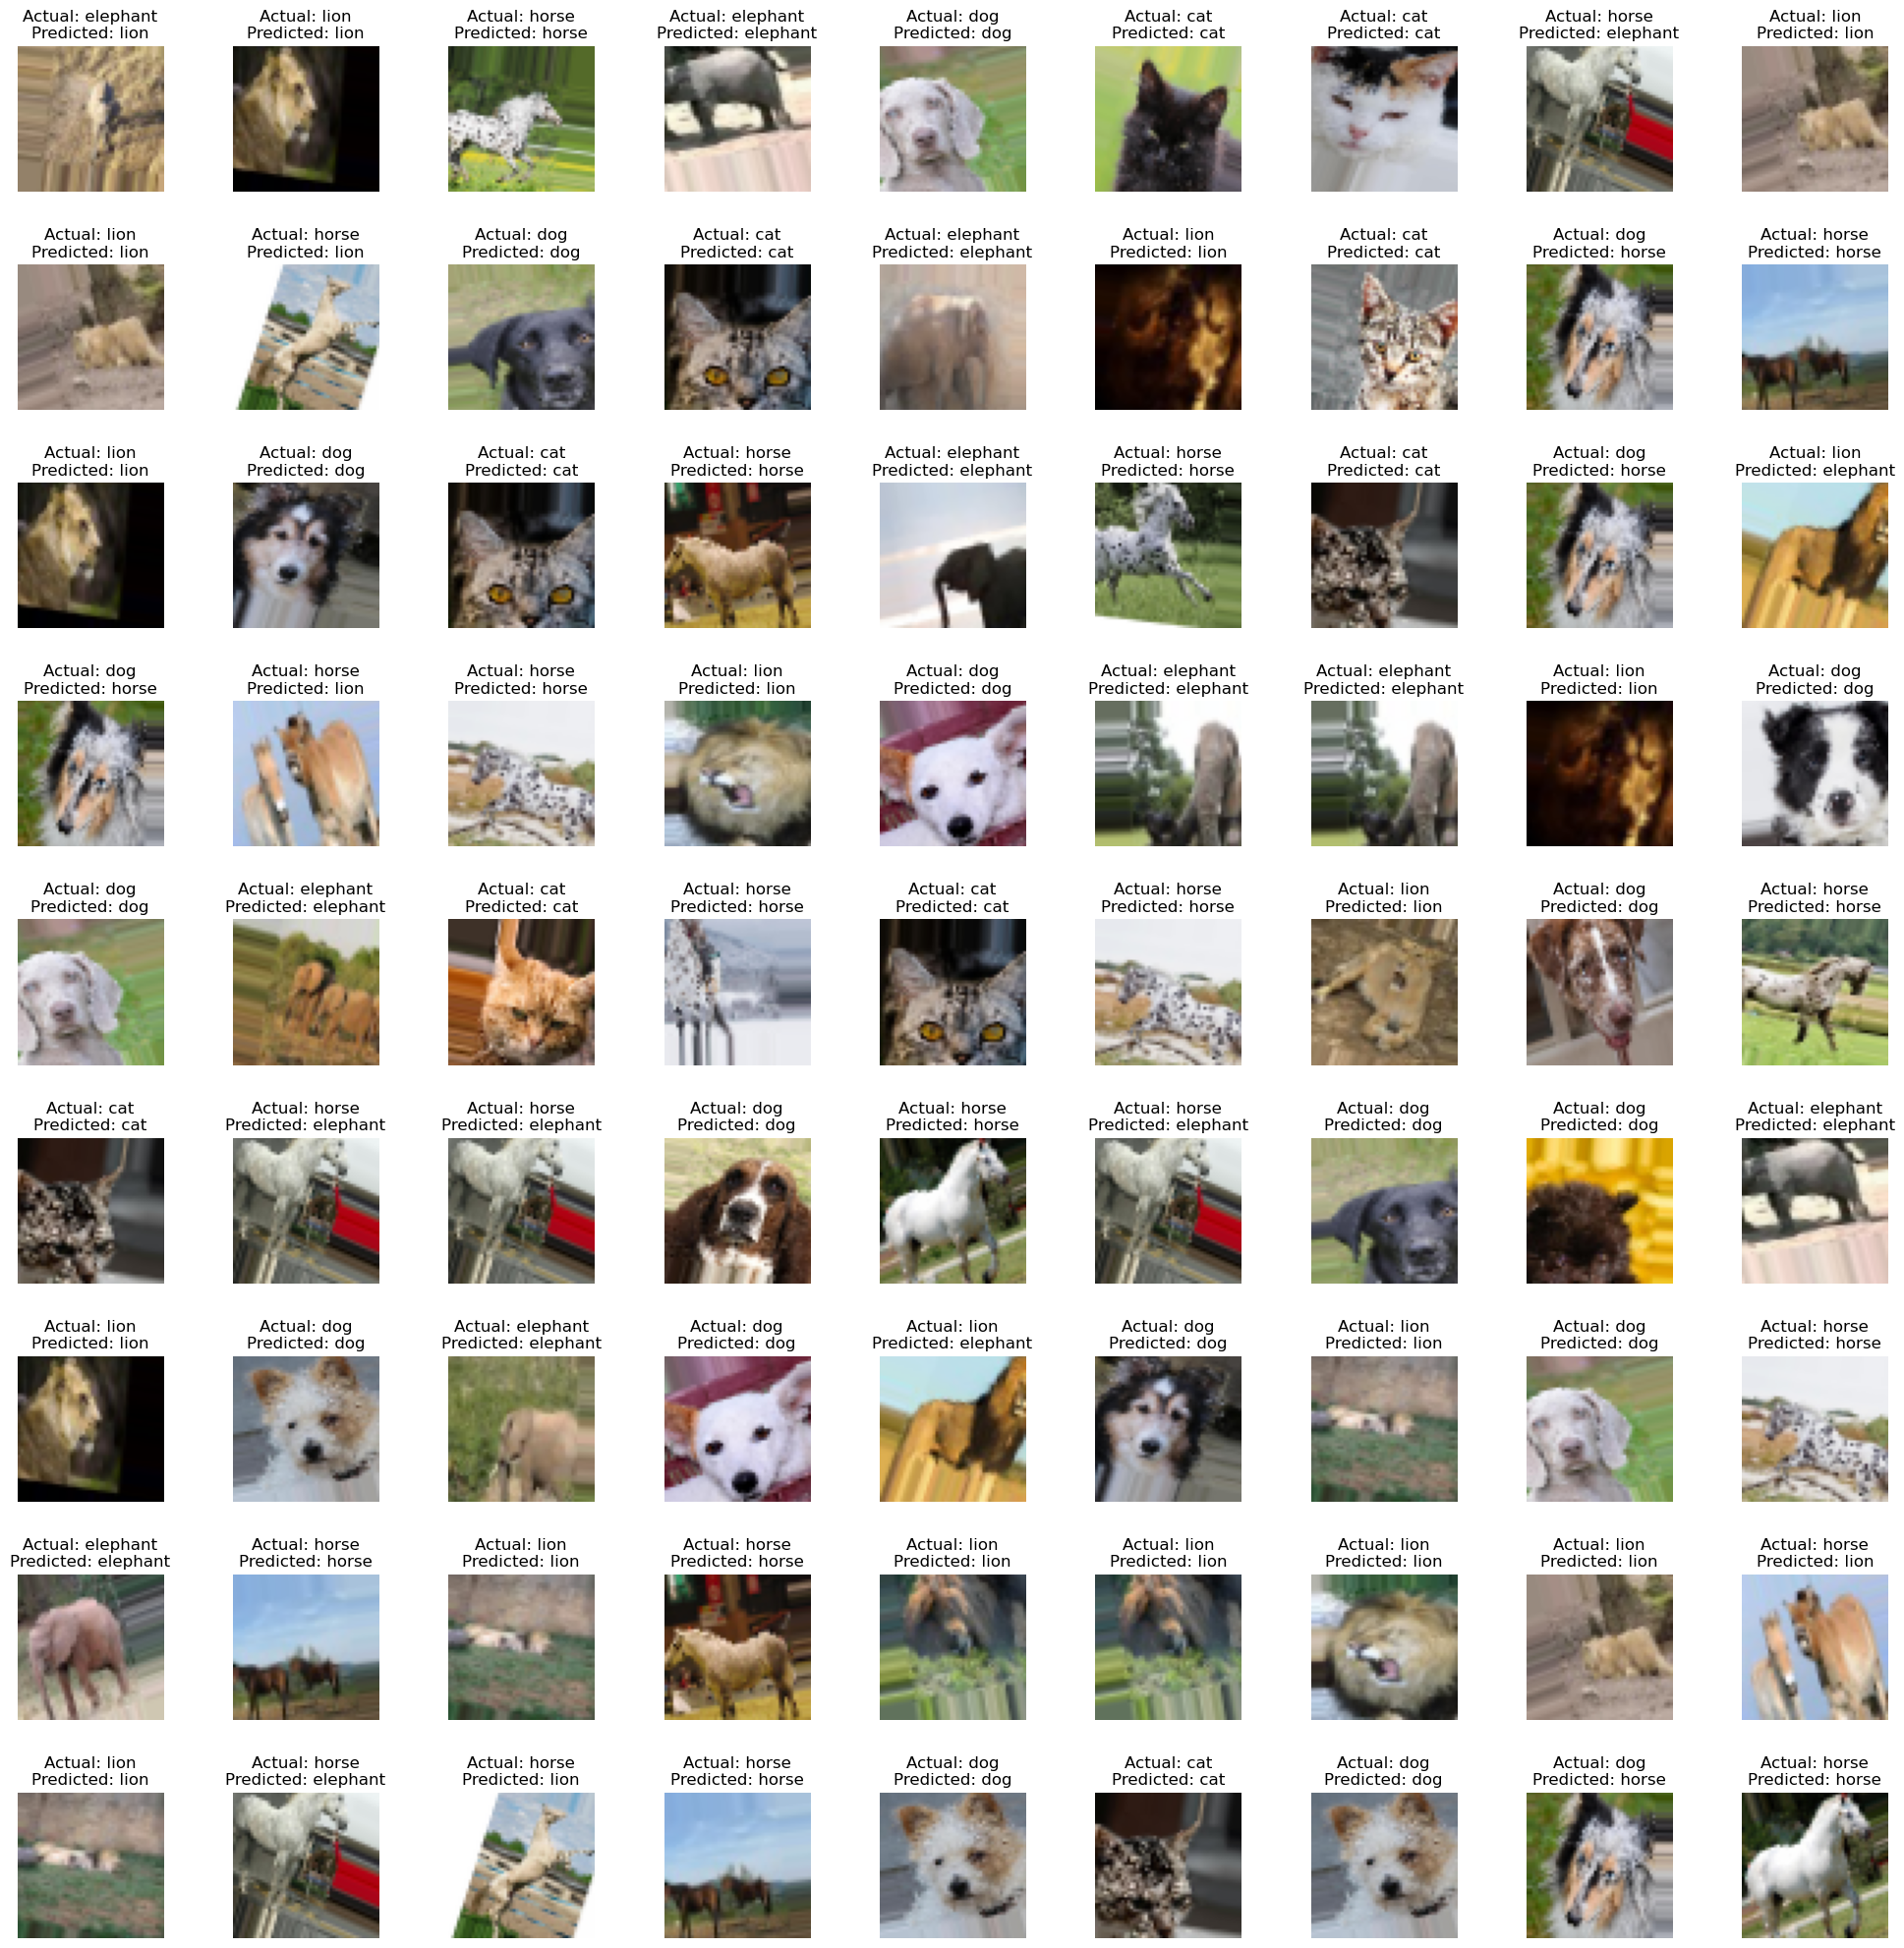

In [25]:
# # Getting the class labels
# class_labels = list(test_generator.class_indices.keys())


# # Getting predictions
# predictions = cnn_model.predict(X_batch)
# predicted_classes = np.argmax(predictions, axis=1)
# actual_classes = np.argmax(y_batch, axis=1)

# # Defining grid dimensions
# L_grid = 9
# W_grid = 9

# # Creating a figure with a grid of subplots
# fig, axes = plt.subplots(L_grid, W_grid, figsize=(25, 25))
# axes = axes.ravel()

# # Plotting the images and their predictions
# for i in range (L_grid * W_grid):
#     index = np.random.randint(0, X_batch.shape[0])
#     axes[i].imshow(X_batch[index])
#     axes[i].set_title(f"Actual: {class_labels[actual_classes[index]]}\nPredicted: {class_labels[predicted_classes[index]]}")
#     axes[i].axis('off')


# plt.subplots_adjust(hspace=0.5)
# plt.show()



# Assuming the test_generator has been defined and the model has been trained
# Get a batch of images and labels from the test dataset
X_batch, y_batch = next(test_generator)

# Getting the class labels
class_labels = list(test_generator.class_indices.keys())

# Getting predictions
predictions = cnn_model.predict(X_batch)
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(y_batch, axis=1)

# Defining grid dimensions
L_grid = 9
W_grid = 9

# Creating a figure with a grid of subplots
fig, axes = plt.subplots(L_grid, W_grid, figsize=(25, 25))
axes = axes.ravel()

# Plotting the images and their predictions
for i in range(L_grid * W_grid):
    index = np.random.randint(0, X_batch.shape[0])
    axes[i].imshow(X_batch[index])
    axes[i].set_title(f"Actual: {class_labels[actual_classes[index]]}\nPredicted: {class_labels[predicted_classes[index]]}")
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)
plt.show()


In [26]:
import os

directory = os.path.join(os.getcwd(), 'saved_model_iteration_final_1')

if not os.path.isdir(directory):
    os.makedirs(directory)
model_path = os.path.join(directory, 'animal_identifier_trained_model_final_1.h5')
cnn_model.save(model_path)